In [1]:
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr

from statsmodels.regression.linear_model import OLS

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.dpi'] = 100
sns.set_style("darkgrid")

In [3]:
random_seed = 1923
rng = np.random.default_rng(random_seed)

## Data generation

In [4]:
# Relationship
true_intercept = 5
true_slope = 2

# Predictor
n_obs = 100
x_mean = 5
x_sd = 3
x = rng.normal(x_mean, x_sd, n_obs)
xarray = xr.DataArray(x, dims = ["plot_dim"])

# Target
true_line = true_intercept + true_slope * x
noise_mean = 0
noise_sd = 5
noise = rng.normal(noise_mean, noise_sd, n_obs)
y = true_line + noise

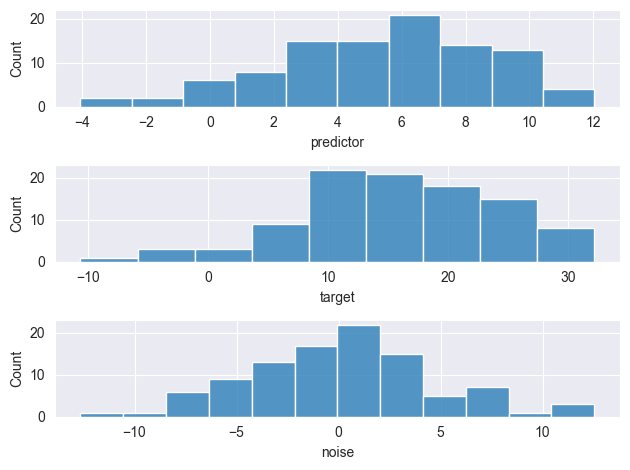

In [5]:
# Distributions of data
fig, ax = plt.subplots(3)

_ = sns.histplot(x, ax = ax[0])
_ = ax[0].set_xlabel("predictor")

_ = sns.histplot(y, ax = ax[1])
_ = ax[1].set_xlabel("target")

_ = sns.histplot(noise, ax = ax[2])
_ = ax[2].set_xlabel("noise")

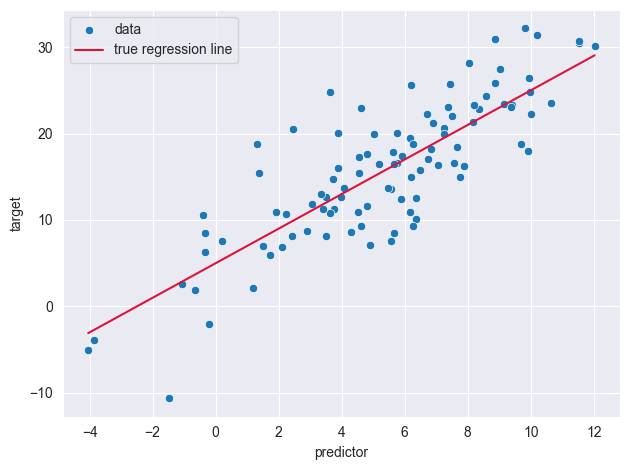

In [6]:
# True regression line
_ = sns.scatterplot(x = x, y = y, label = "data")
_ = sns.lineplot(x = x, y = true_line, label = "true regression line", color = "crimson")
_ = plt.xlabel("predictor")
_ = plt.ylabel("target")

## Frequentist OLS

In [7]:
constant = np.ones(n_obs)
exog = np.stack([x, constant]).transpose()

In [8]:
ols = OLS(endog = y, exog = exog)

In [9]:
ols_res = ols.fit()
ols_fitted = ols.predict(ols_res.params, exog)

In [10]:
ols_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     222.3
Date:                Tue, 16 Jan 2024   Prob (F-statistic):           6.01e-27
Time:                        18:08:44   Log-Likelihood:                -293.67
No. Observations:                 100   AIC:                             591.3
Df Residuals:                      98   BIC:                             596.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.0569      0.138     14.911      0.000       1.783       2.331
const          4.8731      0.870      5.603      0.000       3.147       6.599
==============================================================================
Omnibus:                        1.386   Durbin-Watson:                   2.243
Prob(Omnibus):                  0.500   Jarque-Bera (JB):                0.874
Skew:                           0.176   Prob(JB):                        0.646
Kurtosis:                       3.293   Cond. No.                         12.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

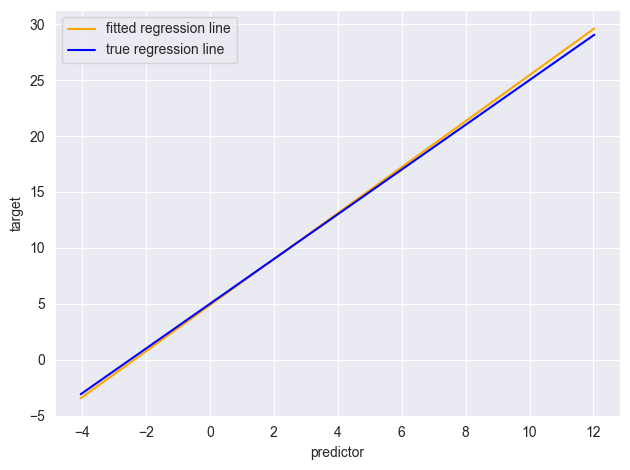

In [11]:
_ = sns.lineplot(
    x = x, 
    y = ols_fitted, 
    label = "fitted regression line", color = "orange")
_ = sns.lineplot(
    x = x, 
    y = true_line, 
    label = "true regression line", color = "blue")
_ = plt.xlabel("predictor")
_ = plt.ylabel("target")

## Flat prior


In [12]:
# Create model
flat_model = pm.Model()

In [13]:
# Define priors & likelihood
with flat_model:

    # Flat priors for all parameters
    intercept = pm.Normal("intercept", mu = 0, sigma = 10)
    slope = pm.Normal("slope", mu = 0, sigma = 10)
    error = pm.Normal("error", mu = 0, sigma = 10)

    # Expected value
    cond_mean = intercept + slope * x 

    # Likelihood
    likelihood = pm.Normal("outcome", mu = cond_mean, sigma = error, observed = y)

In [14]:
# Sample from the prior
with flat_model:
    flat_prior = pm.sample_prior_predictive(
        samples = n_obs,
        var_names = ["intercept", "slope"],
        random_seed = rng)

Sampling: [intercept, slope]


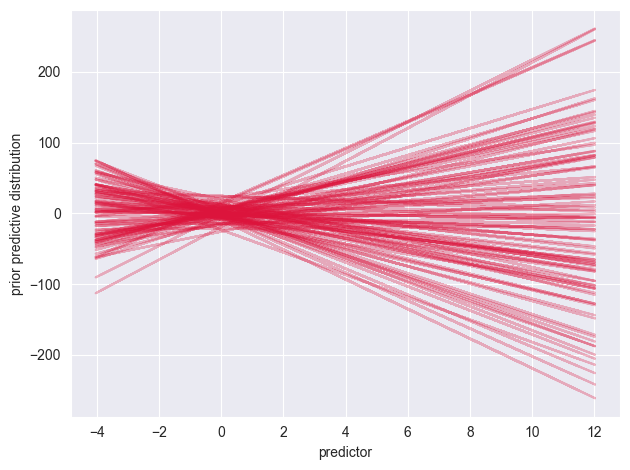

In [15]:
# Prior predictive check
y_flat_prior = (flat_prior.prior["intercept"] + flat_prior.prior["slope"] * xarray).stack(sample=("chain", "draw"))

_ = plt.plot(xarray, y_flat_prior, color = "crimson", alpha = 0.3)
_ = plt.xlabel("predictor")
_ = plt.ylabel("prior predictive distribution")

In [16]:
# Draw posterior samples
with flat_model:
    flat_posterior = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, error]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


In [17]:
# Print posterior distribution summaries
az.summary(flat_posterior, round_to = 4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,4.8290,0.8713,3.1838,6.4380,0.0213,0.0151,1661.4079,1909.7542,1.0009
slope,2.0630,0.1368,1.8119,2.3238,0.0032,0.0023,1854.7359,1774.9948,1.0010
error,4.6535,0.3287,4.0402,5.2511,0.0073,0.0052,2074.0904,2104.1791,1.0000


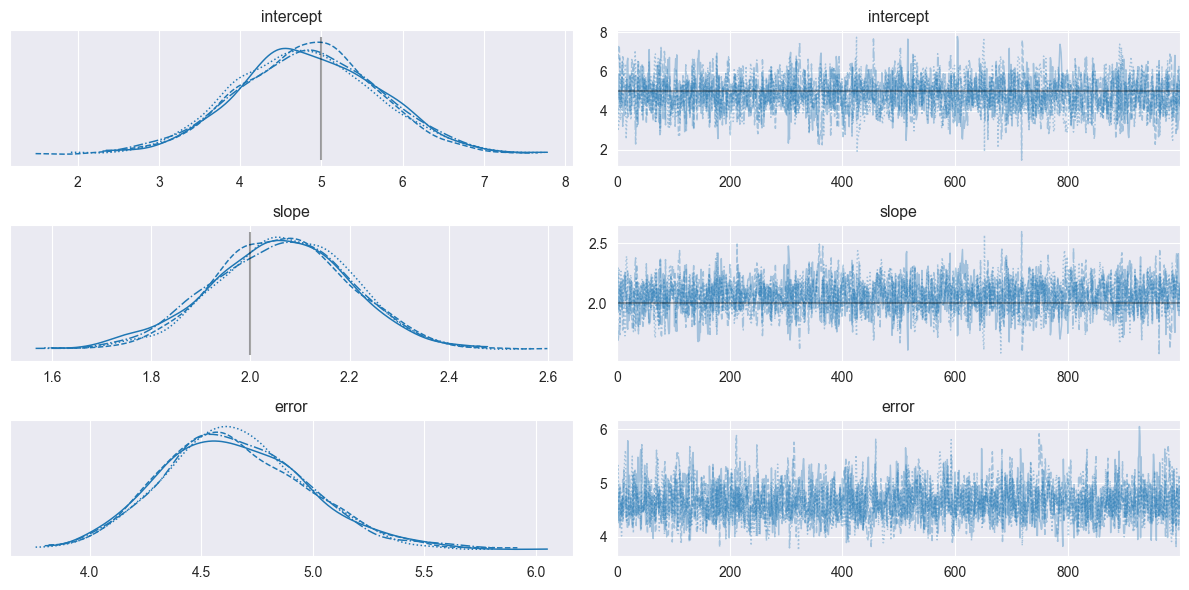

In [18]:
# Plot distribution & sampling chains
_ = az.plot_trace(
    flat_posterior,
    lines = (
        ("intercept", {}, true_intercept),
        ("slope", {}, true_slope)
    )
)

In [19]:
# Simulate fitted regression lines
flat_posterior.posterior["fitted"] = flat_posterior.posterior["intercept"] + flat_posterior.posterior["slope"] * xarray

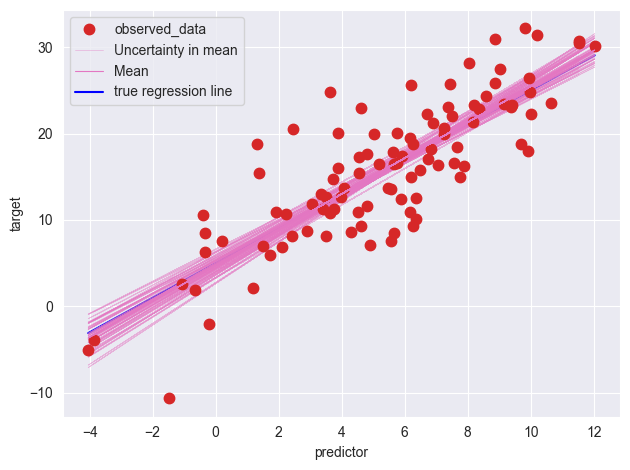

In [20]:
_ = az.plot_lm(
    idata = flat_posterior, 
    x = x, # Predictor values
    y = y, # Real target
    y_model = "fitted" # Fitted regression lines
)
_ = sns.lineplot(
    x = x, 
    y = true_line, 
    label = "true regression line", color = "blue")
_ = plt.xlabel("predictor")
_ = plt.ylabel("target")

In [21]:
# Sample from posterior
with flat_model:
    pm.sample_posterior_predictive(flat_posterior, extend_inferencedata = True, random_seed = rng)

Sampling: [outcome]


C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\BayesianModelingExperiments\venv\lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


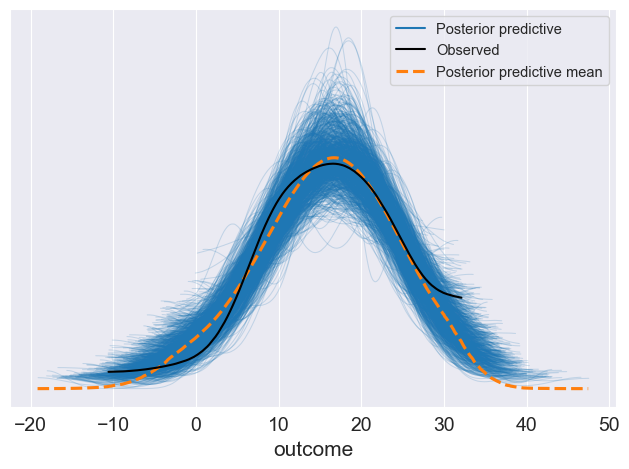

In [22]:
_ = az.plot_ppc(flat_posterior, num_pp_samples = 1000)

## Weakly informative prior

In [23]:
# Create model
weak_model = pm.Model()

In [24]:
# Define priors & likelihood
with weak_model:

    # Flat priors for all parameters
    intercept = pm.Normal("intercept", mu = 3.5, sigma = 2)
    slope = pm.Normal("slope", mu = 1.5, sigma = 1.5)
    error = pm.Normal("error", mu = 0, sigma = 7.5)

    # Expected value
    cond_mean = intercept + slope * x 

    # Likelihood
    likelihood = pm.Normal("outcome", mu = cond_mean, sigma = error, observed = y)

In [25]:
# Sample from the prior
with weak_model:
    weak_prior = pm.sample_prior_predictive(
        samples = n_obs,
        var_names = ["intercept", "slope"],
        random_seed = rng)

Sampling: [intercept, slope]


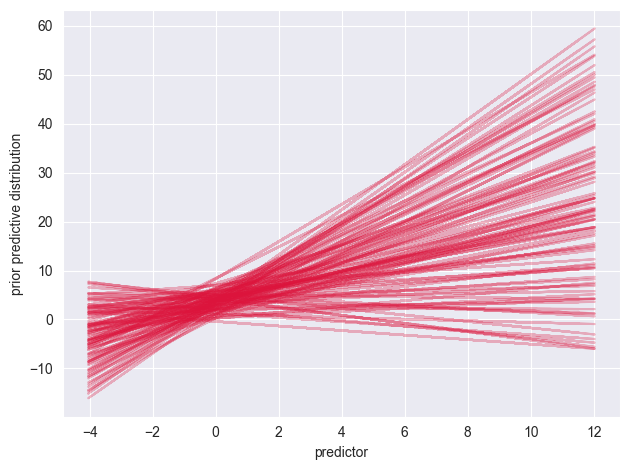

In [26]:
# Prior predictive check
y_weak_prior = (weak_prior.prior["intercept"] + weak_prior.prior["slope"] * xarray).stack(sample=("chain", "draw"))

_ = plt.plot(xarray, y_weak_prior, color = "crimson", alpha = 0.3)
_ = plt.xlabel("predictor")
_ = plt.ylabel("prior predictive distribution")

In [27]:
# Draw posterior samples
with weak_model:
    weak_posterior = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, error]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


In [28]:
# Print posterior distribution summaries
az.summary(weak_posterior, round_to = 4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,4.6745,0.7855,3.2250,6.2219,0.0194,0.0138,1649.9786,1941.0971,1.0019
slope,2.0822,0.1272,1.8420,2.3157,0.0031,0.0022,1661.5538,1910.9682,1.0023
error,4.6518,0.3382,4.0657,5.3200,0.0072,0.0051,2318.3015,1974.7438,1.0014


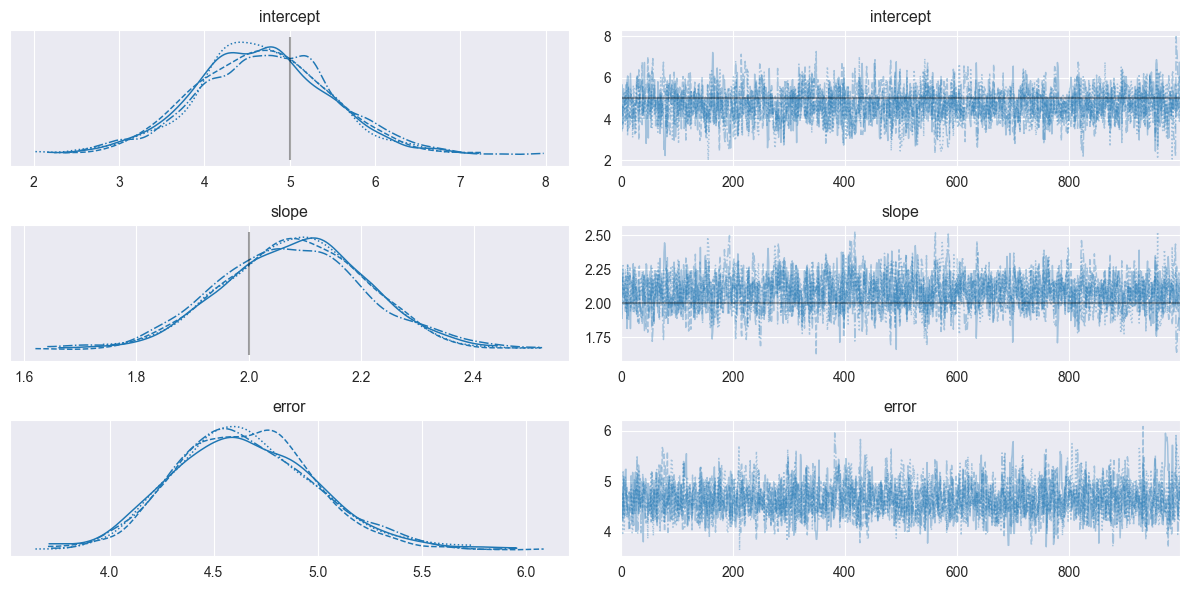

In [29]:
# Plot distribution & sampling chains
_ = az.plot_trace(
    weak_posterior,
    lines = (
        ("intercept", {}, true_intercept),
        ("slope", {}, true_slope)
    )
)

In [30]:
# Simulate fitted regression lines
weak_posterior.posterior["fitted"] = weak_posterior.posterior["intercept"] + weak_posterior.posterior["slope"] * xarray

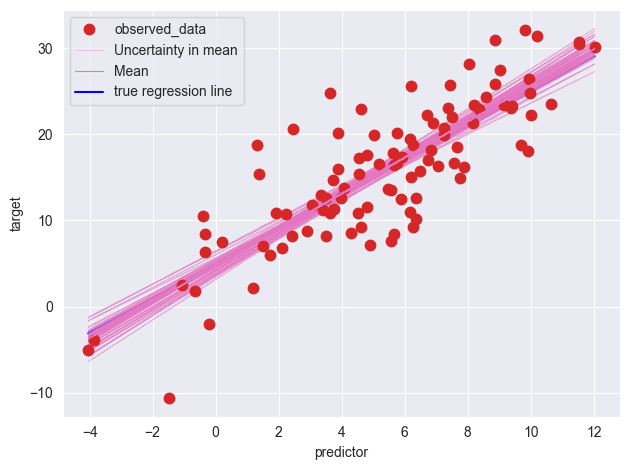

In [31]:
_ = az.plot_lm(
    idata = weak_posterior, 
    x = x, # Predictor values
    y = y, # Real target
    y_model = "fitted" # Fitted regression lines
)
_ = sns.lineplot(
    x = x, 
    y = true_line, 
    label = "true regression line", color = "blue")
_ = plt.xlabel("predictor")
_ = plt.ylabel("target")

In [32]:
# Sample from posterior
with weak_model:
    pm.sample_posterior_predictive(weak_posterior, extend_inferencedata = True, random_seed = rng)

Sampling: [outcome]


C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\BayesianModelingExperiments\venv\lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


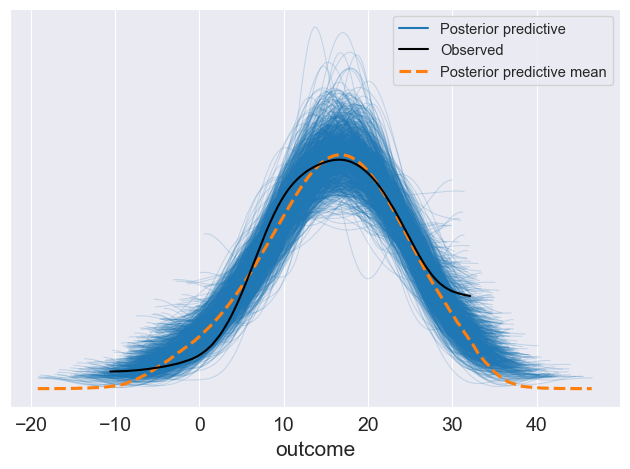

In [33]:
_ = az.plot_ppc(weak_posterior, num_pp_samples = 1000)

## Strong informative prior

In [34]:
# Create model
strong_model = pm.Model()

In [35]:
# Define priors & likelihood
with strong_model:

    # Flat priors for all parameters
    intercept = pm.Normal("intercept", mu = 4.5, sigma = 1)
    slope = pm.Normal("slope", mu = 1.5, sigma = 0.5)
    error = pm.Normal("error", mu = 0, sigma = 5)

    # Expected value
    cond_mean = intercept + slope * x 

    # Likelihood
    likelihood = pm.Normal("outcome", mu = cond_mean, sigma = error, observed = y)

In [36]:
# Sample from the prior
with strong_model:
    strong_prior = pm.sample_prior_predictive(
        samples = n_obs,
        var_names = ["intercept", "slope"],
        random_seed = rng)

Sampling: [intercept, slope]


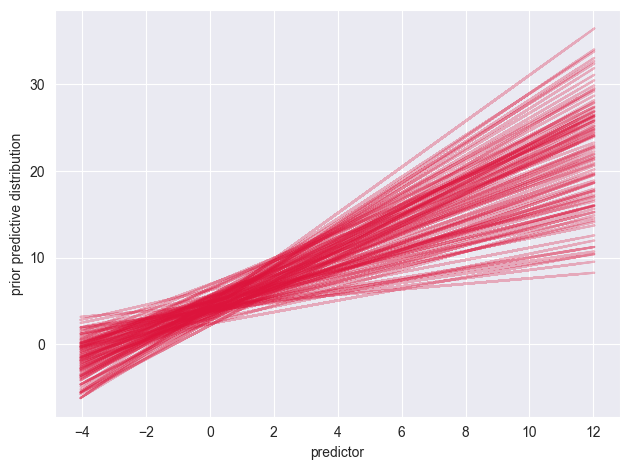

In [37]:
# Prior predictive check
y_strong_prior = (strong_prior.prior["intercept"] + strong_prior.prior["slope"] * xarray).stack(sample=("chain", "draw"))

_ = plt.plot(xarray, y_strong_prior, color = "crimson", alpha = 0.3)
_ = plt.xlabel("predictor")
_ = plt.ylabel("prior predictive distribution")

In [38]:
# Draw posterior samples
with strong_model:
    strong_posterior = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, error]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


In [39]:
# Print posterior distribution summaries
az.summary(strong_posterior, round_to = 4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,4.8329,0.6742,3.5307,6.0888,0.0169,0.0119,1596.5559,1926.2907,1.0029
slope,2.0495,0.1159,1.8207,2.2556,0.0029,0.0021,1559.8293,2231.2460,1.0024
error,4.6399,0.3391,4.0687,5.3265,0.0067,0.0047,2626.6725,2474.8459,1.0004


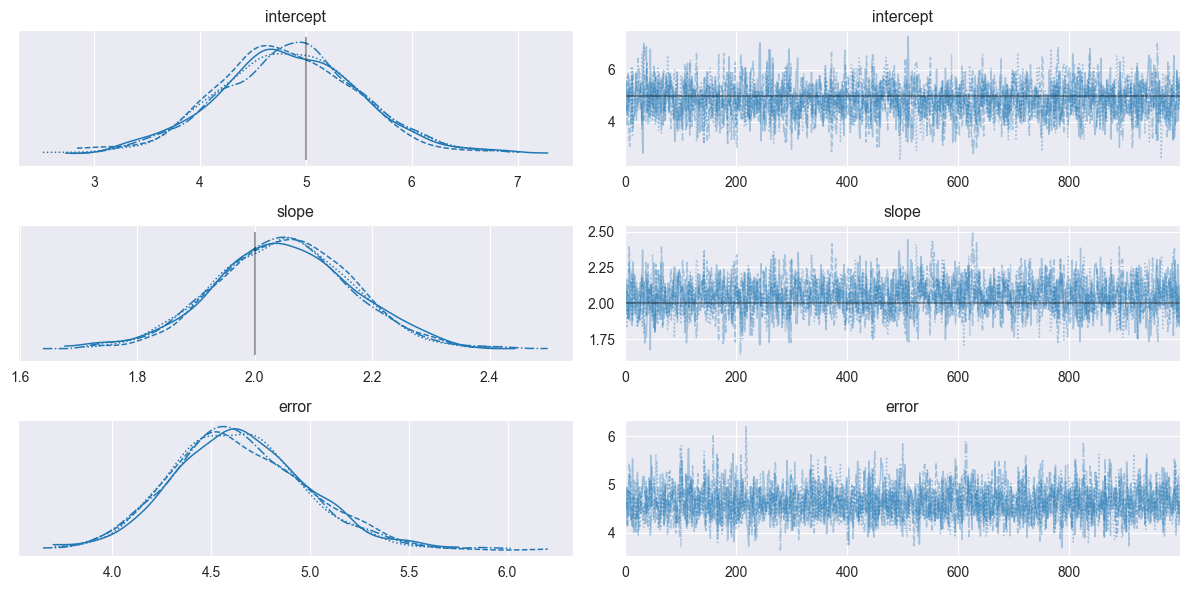

In [40]:
# Plot distribution & sampling chains
_ = az.plot_trace(
    strong_posterior,
    lines = (
        ("intercept", {}, true_intercept),
        ("slope", {}, true_slope)
    )
)

In [41]:
# Simulate fitted regression lines
strong_posterior.posterior["fitted"] = strong_posterior.posterior["intercept"] + strong_posterior.posterior["slope"] * xarray

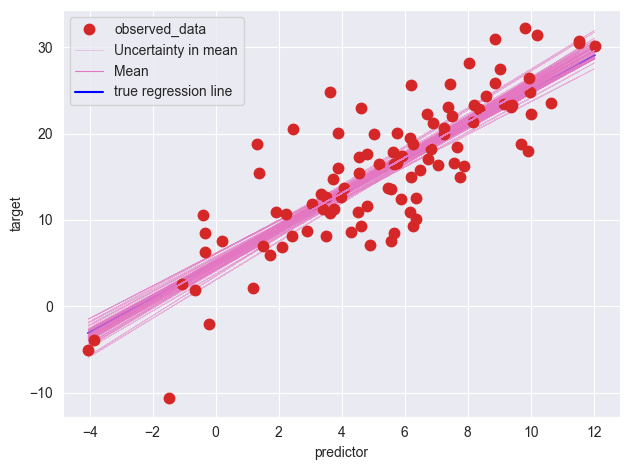

In [42]:
_ = az.plot_lm(
    idata = strong_posterior, 
    x = x, # Predictor values
    y = y, # Real target
    y_model = "fitted" # Fitted regression lines
)
_ = sns.lineplot(
    x = x, 
    y = true_line, 
    label = "true regression line", color = "blue")
_ = plt.xlabel("predictor")
_ = plt.ylabel("target")

In [43]:
# Sample from posterior
with strong_model:
    pm.sample_posterior_predictive(strong_posterior, extend_inferencedata = True, random_seed = rng)

Sampling: [outcome]


C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\BayesianModelingExperiments\venv\lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


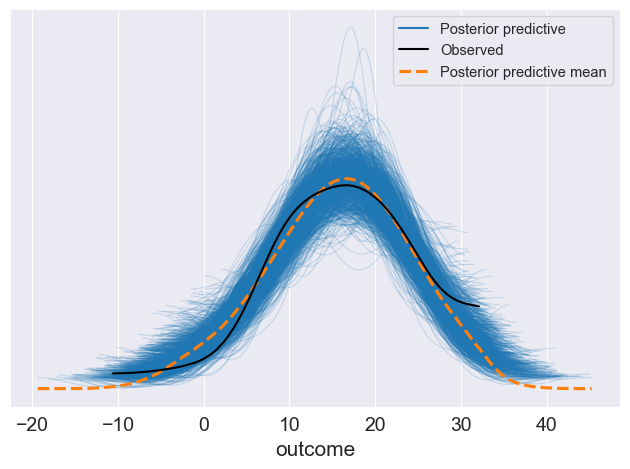

In [44]:
_ = az.plot_ppc(strong_posterior, num_pp_samples = 1000)

## Strong wrong prior

In [45]:
# Create model
wrong_model = pm.Model()

In [46]:
# Define priors & likelihood
with wrong_model:

    # Flat priors for all parameters
    intercept = pm.Normal("intercept", mu = 0, sigma = 1)
    slope = pm.Normal("slope", mu = 5, sigma = 0.5)
    error = pm.Normal("error", mu = 0, sigma = 1)

    # Expected value
    cond_mean = intercept + slope * x 

    # Likelihood
    likelihood = pm.Normal("outcome", mu = cond_mean, sigma = error, observed = y)

In [47]:
# Sample from the prior
with wrong_model:
    wrong_prior = pm.sample_prior_predictive(
        samples = n_obs,
        var_names = ["intercept", "slope"],
        random_seed = rng)

Sampling: [intercept, slope]


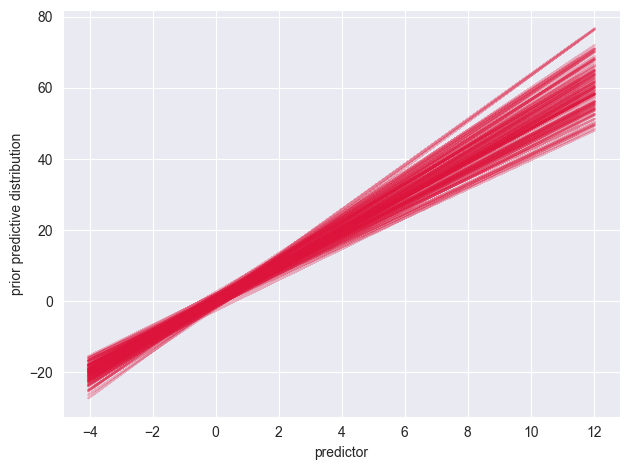

In [48]:
# Prior predictive check
y_wrong_prior = (wrong_prior.prior["intercept"] + wrong_prior.prior["slope"] * xarray).stack(sample=("chain", "draw"))

_ = plt.plot(xarray, y_wrong_prior, color = "crimson", alpha = 0.3)
_ = plt.xlabel("predictor")
_ = plt.ylabel("prior predictive distribution")

In [49]:
# Draw posterior samples
with wrong_model:
    wrong_posterior = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, error]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [50]:
# Print posterior distribution summaries
az.summary(wrong_posterior, round_to = 4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,2.3307,0.6530,1.0930,3.5403,0.0155,0.0109,1782.3171,1985.8368,1.0037
slope,2.4498,0.1125,2.2352,2.6596,0.0026,0.0019,1857.8184,2135.1439,1.0027
error,4.4228,0.2798,3.8986,4.9425,0.0063,0.0045,1977.7181,1884.6003,1.0017


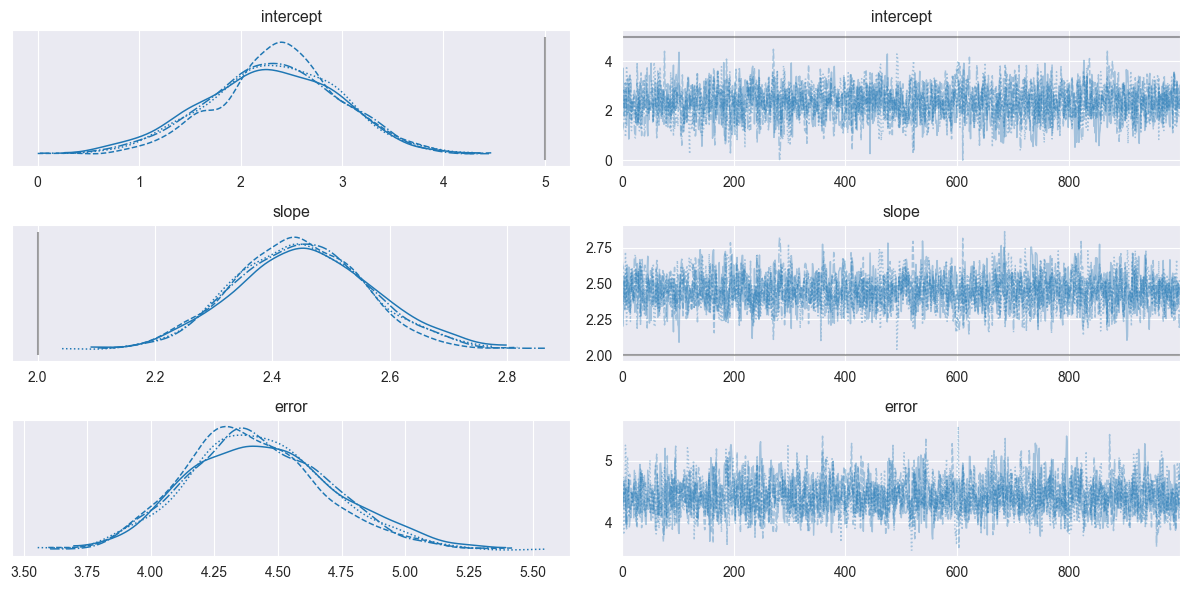

In [51]:
# Plot distribution & sampling chains
_ = az.plot_trace(
    wrong_posterior,
    lines = (
        ("intercept", {}, true_intercept),
        ("slope", {}, true_slope)
    )
)

In [52]:
# Simulate fitted regression lines
wrong_posterior.posterior["fitted"] = wrong_posterior.posterior["intercept"] + wrong_posterior.posterior["slope"] * xarray

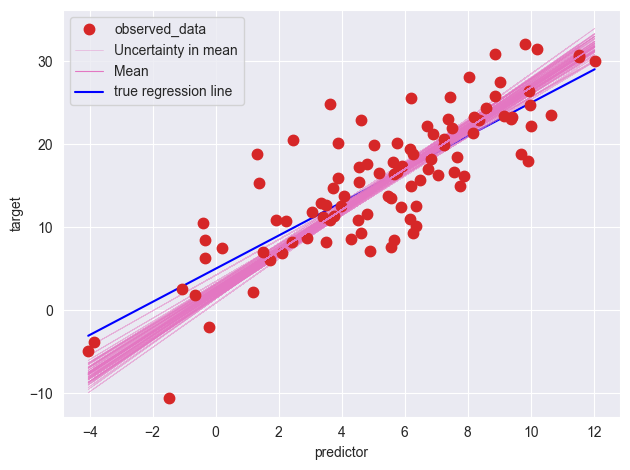

In [53]:
_ = az.plot_lm(
    idata = wrong_posterior, 
    x = x, # Predictor values
    y = y, # Real target
    y_model = "fitted" # Fitted regression lines
)
_ = sns.lineplot(
    x = x, 
    y = true_line, 
    label = "true regression line", color = "blue")
_ = plt.xlabel("predictor")
_ = plt.ylabel("target")

In [54]:
# Sample from posterior
with wrong_model:
    pm.sample_posterior_predictive(wrong_posterior, extend_inferencedata = True, random_seed = rng)

Sampling: [outcome]


C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\BayesianModelingExperiments\venv\lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


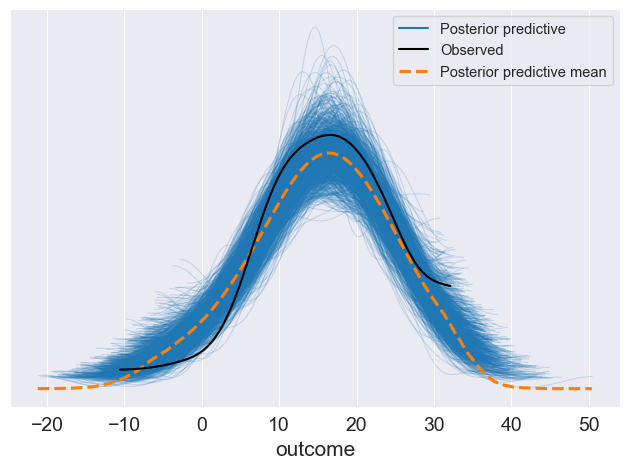

In [55]:
_ = az.plot_ppc(wrong_posterior, num_pp_samples = 1000)